$\large \text{REQUIREMENT 4: BEST-OF-BOTH-WORLD WITH MULTIPLE PRODUCTS}$

$\text{PART 1: Build a pricing strategy using a primal-dual method with the inventory constraint (stochastic environment)}$

In [1]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import uniform,beta
import itertools

In [2]:
############################################################ CLASS BUYER ###################################################################################################################

class buyer():
    
    def __init__(self,N, prices, costs, T):
        
        #Time horizon
        self.T=T
        
        #Set of possible prices
        self.prices=prices
        
        #Number of products
        self.N =N  
        
        #Valuations of each product are indipendent uniformly distributed random variabiles. 
        #Each distribution has a different mean and a different domain 
        #REMARK: the domain is a subset of [0,1]
        self.valuations = np.zeros((self.N, self.T))
        sell_probabilities_list = []
        
        means = np.linspace(0.2, 0.8, self.N) # Vector of the means of the N distributions
        L = 0.4  #Width of the intervals of the distributions
        
        #Generate valuations and selling probabilities
        for n, mu in enumerate(means):
            low = max(0, mu - L/2)
            high = min(1, mu + L/2)
            dist = uniform(loc=low, scale=high - low)
            for t in range(self.T):
                self.valuations[n, t] = dist.rvs()
                sell_probs = 1 - dist.cdf(prices)
                sell_probabilities_list.append(sell_probs)


        #Matrix containing in each row the vectors sell_prob for each one of the N products
        self.sell_probabilities_matrix = np.vstack(sell_probabilities_list)
        
        #Current round
        self.t = 0
        
        #Production costs
        self.production_costs=costs

    def round(self, p_t_vector):

        s_t_vector = np.zeros(self.N, dtype=int)
        f_t_vector = np.zeros(self.N)
        
        ##No selling procedure
        if  np.all(p_t_vector == -1):

            return s_t_vector, f_t_vector

        else:
            for i in range(self.N):
                
                #If the buyer buys the product we return 1 (0 othewise)
                s_t_vector[i] = int(self.prices[p_t_vector[i]] < self.valuations[i, self.t])

                #Chosen price
                price = self.prices[p_t_vector[i]]

                # utility
                f_t_vector[i] = (price - self.production_costs[i]) * s_t_vector[i]
                
            #Update the current round
            self.t += 1
            
            return s_t_vector, f_t_vector    

In [3]:
############################################################ HEDGE ###################################################################################################################

class HedgeAgent:
    
    def __init__(self,N, K, learning_rate):
        
        #Number of possible prices
        self.K = K
        
        #Number of products
        self.N=N
        
        #Learning rate
        self.learning_rate = learning_rate

        #Weights
        self.weights = np.ones((N,K))
        
        #Distribution
        self.x_t = np.ones((N,K))/K

        #Chosen prices (indices)
        self.p_t=-1*np.ones(self.N,dtype=int)

        #Current round
        self.t = 0

    def pull_arm(self):

        for n in range(self.N):
            
            #Update the distributions
            self.x_t[n,:] = self.weights[n,:]/(np.sum(self.weights[n,:]))
            
            #Sample the prices from the respective distributions
            self.p_t[n] = np.random.choice(np.arange(self.K), p=self.x_t[n,:])

        return self.p_t

    def update(self, loss_mat):

        for n in range(self.N):
            
            #Update weights for each (product,price)
            self.weights[n,:] *= np.exp(-self.learning_rate*loss_mat[n,:])
            
        #Update the current round
        self.t += 1

In [4]:
############################################################ CLASS SELLER: ###################################################################################################################
#################################################### MULTIPLICATIVE PACING SELLER ###################################################################################################################

class MultiplicativePacingSeller():

    def __init__(self, N, prices, production_cost, stock, T, eta):
        
        #Number of products
        self.N=N
        
        #Set of possible prices
        self.prices = prices
        
        #Production costs
        self.production_cost = production_cost
        
        #Number of possible products
        self.K = len(prices)

        #Hedge Agent
        self.hedge = HedgeAgent(self.N, self.K, np.sqrt(np.log(self.K)/T))
        
        #Stock
        self.stock = stock
        
        #Eta
        self.eta = eta
        
        #Time horizon
        self.T = T

        #Budget per round (da modificare?)
        self.rho = np.ones((self.N, self.K)) * (self.stock / self.T)
        
        #Lambda matrix
        self.lmbd = np.ones((self.N,self.K))
        
        #Number of pulls per (product,price)
        self.N_pulls = np.zeros((self.N,self.K),dtype=int)
        
        #Chosen prices
        self.p_t=-1*np.ones(self.N,dtype=int)

    def pull_arm(self):
        
        ##If there is no more stock: do not sell anymore
        if self.stock < self.N: 
            self.p_t=np.full(self.N, -1)
            return self.p_t
        
        #Choose the prices
        self.p_t = self.hedge.pull_arm()
        
        return self.p_t

    def update(self, s_t, buyer_valuation):

            #Matrix of selling results per (product,price)
            S_t = np.zeros((self.N, self.K), dtype=int)
            
            #Matrix of rewards per (product,price)
            F_t = np.zeros((self.N, self.K), dtype=float)
            
            #Matrix of Lagrangian function per (product,price)
            L = np.zeros((self.N, self.K), dtype=float)
            
            #Vector of differences between the maximum price and the production cost of each product
            R_max = np.zeros(self.N)
            
            #Auxiliary matrices (see below)
            L_max = np.zeros((self.N, self.K))
            L_min = np.zeros((self.N, self.K))
            L_norm = np.zeros((self.N, self.K))

            for n in range(self.N):

                #If the buyer buys the product we return 1 (0 othewise)
                S_t[n, :] = (self.prices <= buyer_valuation[n]).astype(int)

                #Utility
                F_t[n, :] = (self.prices - self.production_cost[n]) * S_t[n, :]

                #Lagrangian function
                L[n, :] = F_t[n, :] - self.lmbd[n, :] * (S_t[n, :] - self.rho[n, :])

                #Difference between the maximum price and the production cost
                R_max[n] = np.unique(self.prices)[-2] - self.production_cost[n]

                #Pacing
                pacing_max = np.maximum(-self.lmbd[n, :] * (-self.rho[n, :]),
                                        -self.lmbd[n, :] * (1 - self.rho[n, :]))
                pacing_min = np.minimum(-self.lmbd[n, :] * (-self.rho[n, :]),
                                        -self.lmbd[n, :] * (1 - self.rho[n, :]))

                #Normalization of the Lagrangian
                L_max[n, :] = R_max[n] + pacing_max
                L_min[n, :] = pacing_min
                denom = (L_max[n, :] - L_min[n, :])
                L_norm[n, :] = np.clip((L[n, :] - L_min[n, :]) / denom, 0, 1)
                
                #Update lambda matrix: Online Gradient Descent
                self.lmbd[n,:] = np.clip(self.lmbd[n,:] - self.eta * (self.rho[n,:] - S_t[n,:]), a_min=0, a_max=1/self.rho[n,:])

            #Update Hedge Agent
            self.hedge.update(1 - L_norm)

            #Reduce stock
            sold_quantity = np.sum(s_t)
            self.stock -= sold_quantity

            #Update the matrix of number of pulls
            rows=np.arange(self.N)
            self.N_pulls[rows,self.p_t] += 1


In [5]:
#################################################### CLAIRVOYANT ###################################################################################################################

def compute_clairvoyant(N,K, available_prices, production_costs, rho, sell_probabilities): 
    
    #OUTPUT: clairvoyant utility

    OPT=0
    
    #List of vectors: list of all the possible superarms
    possible_superarms = list(itertools.product(range(K), repeat=N))

    number_of_possible_superarms = len(possible_superarms)
    exp_s_super = np.array([])
    exp_f_super = np.array([])
    
    #Utilities and selling results related to the superarms 
    #REMARK: sell_probabilities are used to make reasonings in expectation
    for C in possible_superarms :

        R=np.arange(N)
        exp_s_super=np.append(exp_s_super, np.sum(sell_probabilities[R,C]))
        exp_f_super=np.append(exp_f_super, np.sum((available_prices[np.array(C)] - production_costs) * sell_probabilities[R, C]))

    #Linear Program
    f = -(exp_f_super)
    A_ub = [exp_s_super]
    b_ub = [rho]
    A_eq = [np.ones(number_of_possible_superarms)]
    b_eq = [1]
    res = optimize.linprog(f, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))

    OPT=-(res.fun)


    return  OPT

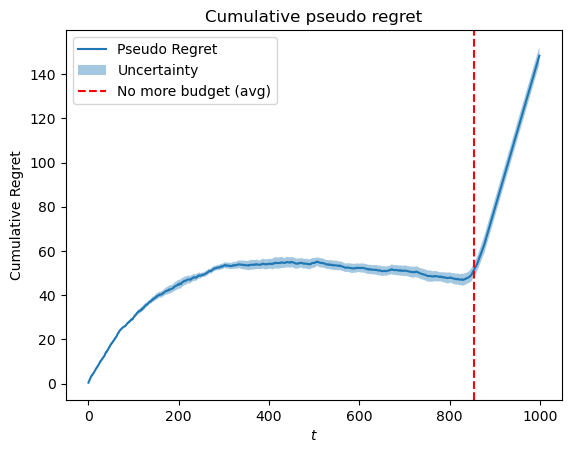

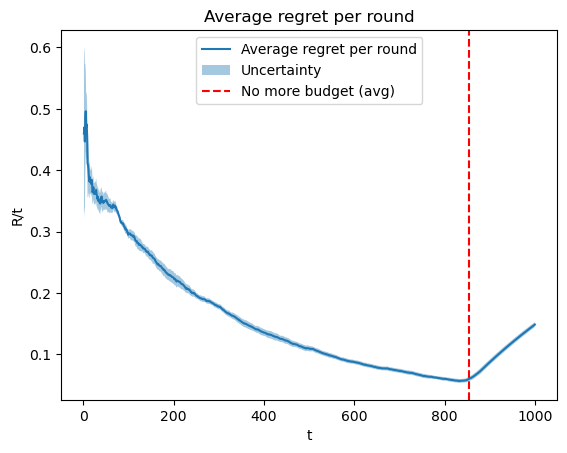

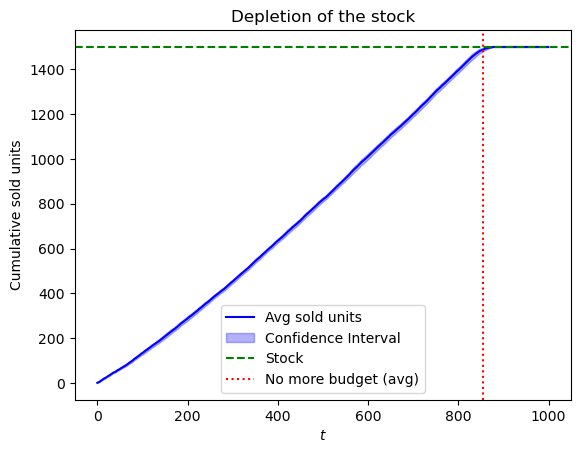

In [6]:
############################################################ EXPERIMENT ###################################################################################################################

N = 3
T = 1000
prices = np.linspace(0.1, 1.1, 11)
c = 0.1*np.ones(N)
K = len(prices)
stock = 1500
rho = stock/T
n_trials = 5
eta = 1/(np.sqrt(T))
regret_per_trial = []
sold_per_trial = []   
exhaustion_times = []   

# CLAIRVOYANT
means = np.linspace(0.2, 0.8, N)   
L = 0.4  

sell_probabilities_list = []
for mu in means:
    low = max(0, mu - L/2)
    high = min(1, mu + L/2)
    dist = uniform(loc=low, scale=high - low)
    sell_probs = 1 - dist.cdf(prices)
    sell_probabilities_list.append(sell_probs)

sell_probabilities_matrix = np.vstack(sell_probabilities_list)
OPT = compute_clairvoyant(N, K, prices, c, rho, sell_probabilities_matrix)

for n in range(n_trials):
    seller = MultiplicativePacingSeller(N, prices, c, stock, T, eta)
    env = buyer(N, prices, c, T)

    seller_utilities = np.array([])
    products_sold = np.array([])

    for u in range(T):
        vect_p_t = seller.pull_arm()
        if np.all(vect_p_t == -1):
            exhaustion_times.append(u)
            seller_utilities = np.append(seller_utilities, np.zeros(T - len(seller_utilities)))
            products_sold = np.append(products_sold, np.zeros(T - len(products_sold)))
            break
        else:
            vect_s_t, vect_f_t = env.round(vect_p_t)
            S_t = np.sum(vect_s_t)
            F_t = np.sum(vect_f_t)
            val = env.valuations[:, u]
            seller.update(vect_s_t, val)
            seller_utilities = np.append(seller_utilities, F_t)
            products_sold = np.append(products_sold, S_t)

    # Cumulative regret
    vect_1 = np.repeat(OPT, T)
    cumulative_regret = np.cumsum(vect_1 - seller_utilities)
    regret_per_trial.append(cumulative_regret)

    # Cumulative sold units
    sold_per_trial.append(np.cumsum(products_sold))

regret_per_trial = np.array(regret_per_trial)
sold_per_trial = np.array(sold_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

avg_cumulative_sold = sold_per_trial.mean(axis=0)
sold_sd = sold_per_trial.std(axis=0)

avg_exhaustion_time = int(np.mean(exhaustion_times)) if exhaustion_times else None

############################################################ PLOTS ###################################################################################################################

# Plot 1: Cumulative pseudo regret
plt.plot(np.arange(T), average_regret, label='Pseudo Regret')
plt.fill_between(np.arange(T),
                 average_regret - regret_sd/np.sqrt(n_trials),
                 average_regret + regret_sd/np.sqrt(n_trials),
                 alpha=0.4, label='Uncertainty')
plt.title('Cumulative pseudo regret')
plt.xlabel('$t$')
plt.ylabel('Cumulative Regret')
if avg_exhaustion_time is not None:
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle='--', label='No more budget (avg)')
plt.legend()
plt.show()

# Plot 2: Average regret per round
times = np.arange(1, T+1)
plt.plot(times, average_regret / times, label='Average regret per round')
plt.fill_between(times,
                 average_regret/times - regret_sd/(np.sqrt(n_trials)*times),
                 average_regret/times + regret_sd/(np.sqrt(n_trials)*times),
                 alpha=0.4, label='Uncertainty')
plt.title('Average regret per round')
plt.xlabel('t')
plt.ylabel('R/t')
if avg_exhaustion_time is not None:
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle='--', label='No more budget (avg)')
plt.legend()
plt.show()

# Plot 3: Number of units sold vs time with IC
ci_upper = avg_cumulative_sold + sold_sd/np.sqrt(n_trials)
ci_lower = avg_cumulative_sold - sold_sd/np.sqrt(n_trials)

plt.plot(np.arange(T), avg_cumulative_sold, label="Avg sold units", color="blue")
plt.fill_between(np.arange(T), ci_lower, ci_upper, color="blue", alpha=0.3, label="Confidence Interval")
plt.axhline(y=stock, color='green', linestyle='--', label='Stock')
if avg_exhaustion_time is not None:
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle=':', label='No more budget (avg)')
plt.xlabel("$t$")
plt.ylabel("Cumulative sold units")
plt.title("Depletion of the stock")
plt.legend()
plt.show()



$\text{PART 2: Build a pricing strategy using a primal-dual method with the inventory constraint (higly non-stationary environment)}$

In [7]:
#Import libraries (same as above)
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import uniform,beta
import itertools

In [8]:
############################################################ CLASS BUYER ###################################################################################################################

class buyer():
    
    def __init__(self, N, T, R, prices, costs):
        
        #Set of possible prices
        self.prices = prices
        
        #Number of possible prices
        self.K = len(self.prices)
        
        #Number of products
        self.N = N  
        
        #Time horizon
        self.T = T  
        
        #Changing distribution time interval
        self.R = R  
        
        #Production costs
        self.production_costs = costs
        
        #Valuations
        self.valuations = np.zeros((self.N, self.T))
        
        #Matrix of selling results: selling results for each (product,price,round)
        self.selling_results_matrix=np.zeros((self.N, self.K, self.T))
        
        #Reward matrix: rewards for each (product,price,round)
        self.reward_matrix = np.zeros((self.N, self.K, self.T))  
        
        #Matrix of selling probabilities: selling probabilities for each (product,price,round)
        self.sell_probabilities_matrix = np.zeros((self.N, self.K, self.T))

        #Vector of the parameters of the distributions
        params = np.linspace(0.2, 0.8, self.N)
        
        #Current round
        self.t = 0 
        
        
        #Highly non-stationary environment: distributions of the valuations change through time. 
        #All distributions are uniform and every R rounds they change. 
        #FRAMEWORK: the distribution associated to the valuation of the i-th product 
        #switches to the one associated to the valuation of the (i+1)-th product
        for t in range(self.T):
            
            block_idx=t//self.R
  
            if (t % self.R == 0) and (t > 0):
                params=np.concatenate(([params[-1]], params[:-1])) # change the mean

            L = 0.4  # Width of the intervals of the distributions
            
            sell_probabilities_list = []

            #Generate valuations and sell probabilities
            for i, mu in enumerate(params):  
                
                if block_idx % 2 == 0:
                    # blocco pari → Normale centrata su mu
                    dist=beta(mu+1,mu+1)  
                    self.valuations[i,t] = dist.rvs()
                    
                else:
                    low = max(0, mu - L / 2)
                    high = min(1, mu + L / 2)
                    dist = uniform(loc=low, scale=high - low)  
                    self.valuations[i,t]=dist.rvs()  
                                
                sell_probs = 1 - dist.cdf(prices)  
                sell_probabilities_list.append(sell_probs)

                #Compute the selling results and the rewards
                for k in range(self.K):
                    s_t = int(self.prices[k]<=self.valuations[i,t])
                    self.selling_results_matrix[i, k, t]=s_t
                    self.reward_matrix[i, k, t] = (self.prices[k] - self.production_costs[i]) * s_t

            #Matrix containing in each row the vectors sell_prob for each one of the N products for every round
            self.sell_probabilities_matrix[:, :, t] = np.vstack(sell_probabilities_list)
             

    def round(self, p_t_vector):

        s_t_vector = np.zeros(self.N, dtype=int)
        f_t_vector = np.zeros(self.N)
        
        #No more budget: no selling procedure
        if np.all(p_t_vector == -1):  
            return s_t_vector, f_t_vector

        else:
            for i in range(self.N):
                
                #Retrieve the utility
                f_t_vector[i] = self.reward_matrix[i, p_t_vector[i], self.t]

                #Selling results: if the utility is >0 the unit has been sold
                s_t_vector[i] = int(f_t_vector[i] > 0)

            #Update the current round
            self.t += 1
            
            return s_t_vector, f_t_vector


In [9]:
############################################################ HEDGE ###################################################################################################################

class HedgeAgent:
    
    def __init__(self,N, K, learning_rate):
        
        #Number of prices
        self.K = K
        
        #Number of products
        self.N=N
        
        #Learning rate
        self.learning_rate = learning_rate
        
        #Weights for each (product,price)
        self.weights = np.ones((N,K))
        
        #Distributions
        self.x_t = np.ones((N,K))/K
        
        #Chosen prices (vector of indices)
        self.p_t=-1*np.ones(self.N,dtype=int)
        
        #Current round
        self.t = 0

    def pull_arm(self):
        
        for n in range(self.N):
            
            #Update weights
            self.x_t[n,:] = self.weights[n,:]/(np.sum(self.weights[n,:]))
            
            #Choose the price for each product
            self.p_t[n] = np.random.choice(np.arange(self.K), p=self.x_t[n,:])
             
        return self.p_t
    
    def update(self, loss_mat):
        
        for n in range(self.N):
            
            #Update weights for each (product,price)
            self.weights[n,:] *= np.exp(-self.learning_rate*loss_mat[n,:])
            
        #Update the current round
        self.t += 1


In [10]:
######################################################### CLASS SELLER: ###################################################################################################################
################################################# MULTIPLICATIVE PACING SELLER ###################################################################################################################


class MultiplicativePacingSeller():
    
    def __init__(self, N, prices, costs, stock, T, eta):
        
        #Number of products
        self.N=N
        
        #Set of possible prices
        self.prices = prices
        
        #Production costs
        self.production_cost = costs
        
        #Number of possible prices
        self.K = len(prices)
        
        #Hedge Agent
        self.hedge = HedgeAgent(self.N, self.K, np.sqrt(np.log(self.K)/T))
        
        #Stock
        self.stock = stock
        
        #Eta
        self.eta = eta
        
        #Time horizon
        self.T = T
        
        #Budget per round (giusto che sia /self.N?)
        self.rho = np.ones((self.N, self.K)) * (self.stock / (self.N*self.T))  
        
        #Lambda
        self.lmbd = np.ones((self.N,self.K))
        
        #Number of pulls for each (product,price)
        self.N_pulls = np.zeros((self.N,self.K),dtype=int)
        
        #Chosen prices (vector of indices)
        self.p_t=-1*np.ones(self.N,dtype=int)

    def pull_arm(self):
        
        #No more budget available: stop selling procedure
        if self.stock < self.N: 
            self.p_t=np.full(self.N, -1)
            return self.p_t
        
        #Choose the prices
        self.p_t = self.hedge.pull_arm()
        
        return self.p_t

    def update(self, s_t, buyer_valuation):
            
            #Matrix of selling results per (product,price)
            S_t = np.zeros((self.N, self.K), dtype=int)
            
            #Matrix of utilities per (product,price)
            F_t = np.zeros((self.N, self.K), dtype=float)
            
            #Matrix of Lagrangian functions per (product,price)
            L = np.zeros((self.N, self.K), dtype=float)
            
            #Vector of the differences between the maximum of the prices and the production cost of the products
            R_max = np.zeros(self.N)
            
            #Auxiliary matrices (see below)
            L_max = np.zeros((self.N, self.K))
            L_min = np.zeros((self.N, self.K))
            L_norm = np.zeros((self.N, self.K))
        
            for n in range(self.N):
                
                ##If the buyer buys the product we return 1 (0 othewise)
                S_t[n, :] = (self.prices <= buyer_valuation[n]).astype(int)
                
                #Utility 
                F_t[n, :] = (self.prices - self.production_cost[n]) * S_t[n, :]
                
                #Lagrangian function
                L[n, :] = F_t[n, :] - self.lmbd[n, :] * (S_t[n, :] - self.rho[n, :])
                
                #Difference between the maximum of the prices and the production cost for each product
                R_max[n] = np.unique(self.prices)[-2] - self.production_cost[n]
                
                #Pacing
                pacing_max = np.maximum(-self.lmbd[n, :] * (-self.rho[n, :]),
                                        -self.lmbd[n, :] * (1 - self.rho[n, :]))
                pacing_min = np.minimum(-self.lmbd[n, :] * (-self.rho[n, :]),
                                        -self.lmbd[n, :] * (1 - self.rho[n, :]))

                #Normalization of the Lagrangian
                L_max[n, :] = R_max[n] + pacing_max
                L_min[n, :] = pacing_min
                denom = (L_max[n, :] - L_min[n, :])
                L_norm[n, :] = np.clip((L[n, :] - L_min[n, :]) / denom, 0, 1)
                
                #Update lambda: Online Gradient Descent
                self.lmbd[n,:] = np.clip(self.lmbd[n,:] - self.eta * (self.rho[n,:] - S_t[n,:]), a_min=0, a_max=1/self.rho[n,:])
            
            #Update Hedge Agent
            self.hedge.update(1 - L_norm)
            
            #Reduce the stock
            sold_quantity = np.sum(s_t)
            self.stock -= sold_quantity 
            
            #Update the matrix of number of pulls
            rows=np.arange(self.N)
            self.N_pulls[rows,self.p_t] += 1

In [11]:
######################################################### CLAIRVOYANT ###################################################################################################################

def clairvoyant(prices, T, cost, rho, selling_results):
    
    #OUTPUT: clairvoyant utility

    #Number of products
    N = len(cost)
    
    #Number of possible prices
    K = len(prices)
    
    # Emplirical win probabilities
    win_probabilities = np.zeros((N, K))
    for n in range(N):
        for k in range(K):
            num_sold = np.sum(selling_results[n, k, :])
            win_probabilities[n, k] = num_sold / T

    #List of vectors: list of all the possible superarms
    possible_superarms = list(itertools.product(range(K), repeat=N))
    num_superarms = len(possible_superarms)
    
    
    s_super = np.array([])
    f_super = np.array([])

    #Utilities and selling results related to the superarms 
    for idx in possible_superarms:
        
        R=np.arange(N)
        s_super=np.append(s_super, np.sum(win_probabilities[R,idx]))
        f_super=np.append(f_super, np.sum((prices[np.array(idx)] - c) * win_probabilities[R,idx]))

    #Linear Program
    f = - f_super
    A_ub = [s_super]    
    b_ub = [rho]
    A_eq = [np.ones(num_superarms)]  
    b_eq = [1]

    res = optimize.linprog(f, A_ub=A_ub, b_ub=b_ub,
                           A_eq=A_eq, b_eq=b_eq, bounds=(0, 1))

    OPT = -res.fun
    return OPT


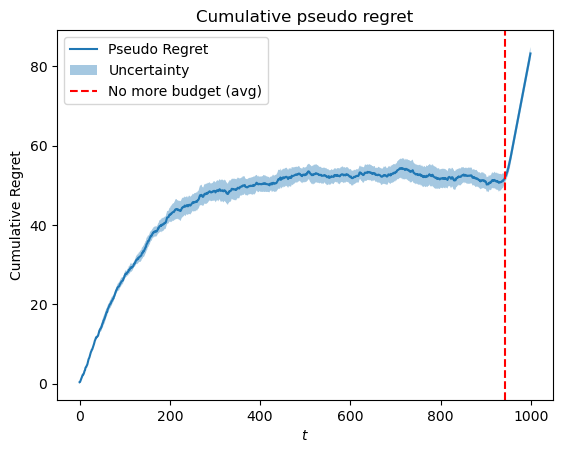

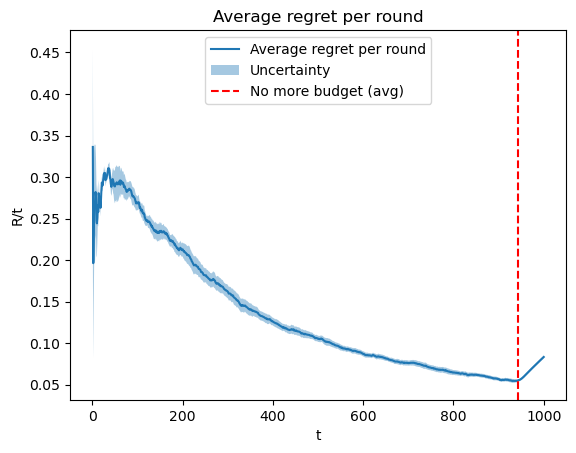

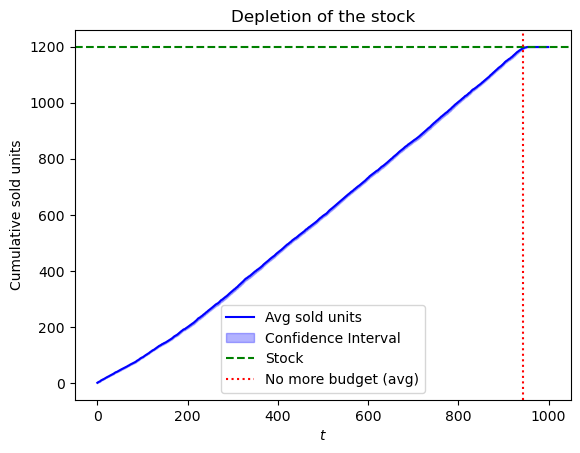

In [12]:
############################################################ EXPERIMENT ###################################################################################################################

# Setting
N = 3
T = 1000 
prices = np.linspace(0.1, 1.1, 11)
c = 0.1*np.ones(N)
K = len(prices)
stock = 1200
R = 3
rho = stock/T
n_trials = 5
eta = 1/(np.sqrt(T))

regret_per_trial = []
sold_per_trial = []
exhaustion_times = []

for n in range(n_trials):

    env = buyer(N, T, R, prices, c)
    
    # CLAIRVOYANT
    OPT = clairvoyant(prices, T, c, rho, env.selling_results_matrix)
    
    seller = MultiplicativePacingSeller(N, prices, c, stock, T, eta)
    
    seller_utilities = np.array([])
    products_sold = np.array([])

    # Experiment
    for t in range(T):
        vect_p_t = seller.pull_arm()        
        if np.all(vect_p_t == -1): 
            exhaustion_times.append(t)
            # Completa con zeri fino a T
            seller_utilities = np.append(seller_utilities, np.zeros(T - len(seller_utilities)))
            products_sold = np.append(products_sold, np.zeros(T - len(products_sold)))
            break
        else:
            vect_s_t, vect_f_t = env.round(vect_p_t)
            S_t = np.sum(vect_s_t)
            F_t = np.sum(vect_f_t)
            val = env.valuations[:, t]
            seller.update(vect_s_t, val)
            seller_utilities = np.append(seller_utilities, F_t)
            products_sold = np.append(products_sold, S_t)
            
    # Cumulative regret
    vect_1 = np.repeat(OPT, T)
    cumulative_regret = np.cumsum(vect_1 - seller_utilities)
    regret_per_trial.append(cumulative_regret)
    
    # Cumulative sold units
    sold_per_trial.append(np.cumsum(products_sold))

regret_per_trial = np.array(regret_per_trial)
sold_per_trial = np.array(sold_per_trial)

# Mean and standard deviation
average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

avg_cumulative_sold = sold_per_trial.mean(axis=0)
sold_sd = sold_per_trial.std(axis=0)

avg_exhaustion_time = int(np.mean(exhaustion_times)) if exhaustion_times else None

############################################################ PLOTS ###################################################################################################################

# Plot 1: Cumulative pseudo regret vs time 
plt.plot(np.arange(T), average_regret, label='Pseudo Regret')
plt.fill_between(np.arange(T),
                 average_regret - regret_sd/np.sqrt(n_trials),
                 average_regret + regret_sd/np.sqrt(n_trials),
                 alpha=0.4,
                 label='Uncertainty')
plt.title('Cumulative pseudo regret')
plt.xlabel('$t$')
plt.ylabel('Cumulative Regret')
if avg_exhaustion_time is not None:
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle='--', label='No more budget (avg)')
plt.legend()
plt.show()

# Plot 2: Average regret per round 
times = np.arange(1, T+1)
plt.plot(times, average_regret / times, label='Average regret per round')
plt.fill_between(times,
                 average_regret/times - regret_sd/(np.sqrt(n_trials)*times),
                 average_regret/times + regret_sd/(np.sqrt(n_trials)*times),
                 alpha=0.4,
                 label='Uncertainty')
plt.title('Average regret per round')
plt.xlabel('t')
plt.ylabel('R/t')
if avg_exhaustion_time is not None:
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle='--', label='No more budget (avg)')
plt.legend()
plt.show()

# Plot 3: Number of units sold vs time with IC
ci_upper = avg_cumulative_sold + sold_sd/np.sqrt(n_trials)
ci_lower = avg_cumulative_sold - sold_sd/np.sqrt(n_trials)

plt.plot(np.arange(T), avg_cumulative_sold, label="Avg sold units", color="blue")
plt.fill_between(np.arange(T), ci_lower, ci_upper, color="blue", alpha=0.3, label="Confidence Interval")
plt.axhline(y=stock, color='green', linestyle='--', label='Stock')
if avg_exhaustion_time is not None:
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle=':', label='No more budget (avg)')
plt.xlabel("$t$")
plt.ylabel("Cumulative sold units")
plt.title("Depletion of the stock")
plt.legend()
plt.show()


